In [1]:
%load_ext autoreload
%autoreload 2

In [80]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from utils_2 import train_segmentation_network, load_warwick, find_best_and_worst_case, visualize_case

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
batch_size = 16
X_train, Y_train, X_test, Y_test = load_warwick(device)
# create dataloader
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/1000, Train Loss: 0.7188, Test Loss: 0.7181, Train Dice Score: 0.4917, Test Dice Score: 0.4922
Epoch 2/1000, Train Loss: 0.7142, Test Loss: 0.7154, Train Dice Score: 0.5005, Test Dice Score: 0.4870
Epoch 3/1000, Train Loss: 0.7110, Test Loss: 0.7130, Train Dice Score: 0.4936, Test Dice Score: 0.4229
Epoch 4/1000, Train Loss: 0.7069, Test Loss: 0.7078, Train Dice Score: 0.4477, Test Dice Score: 0.3647
Epoch 5/1000, Train Loss: 0.7003, Test Loss: 0.7030, Train Dice Score: 0.3651, Test Dice Score: 0.2698
Epoch 6/1000, Train Loss: 0.6917, Test Loss: 0.7002, Train Dice Score: 0.3139, Test Dice Score: 0.2937
Epoch 7/1000, Train Loss: 0.6829, Test Loss: 0.6991, Train Dice Score: 0.3570, Test Dice Score: 0.3811
Epoch 8/1000, Train Loss: 0.6744, Test Loss: 0.7017, Train Dice Score: 0.3849, Test Dice Score: 0.4207
Epoch 9/1000, Train Loss: 0.6661, Test Loss: 0.7030, Train Dice Score: 0.3935, Test Dice Score: 0.4309
Epoch 10/1000, Train Loss: 0.6570, Test Loss: 0.6895, Train Dice Score: 0

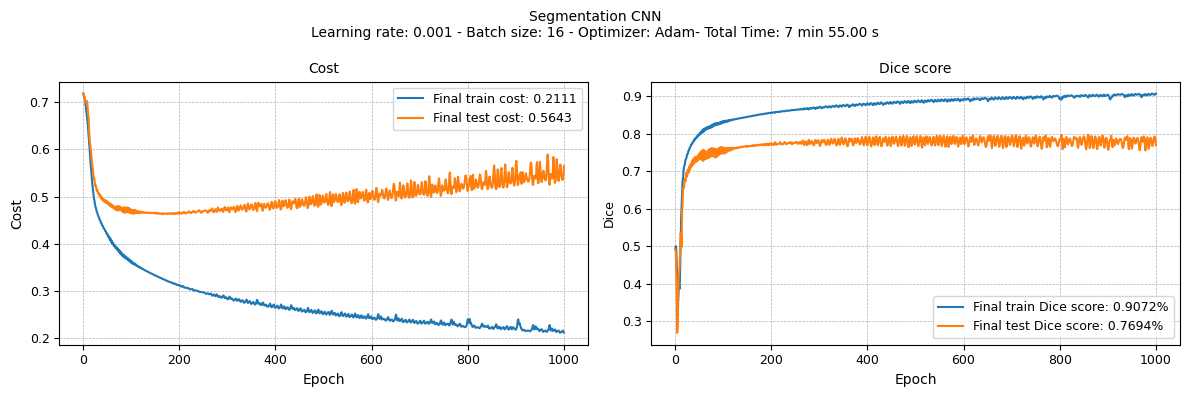

In [64]:
# Define the modified CNN architecture
class SegmentationCNN(nn.Module):
    def __init__(self):
        super(SegmentationCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()

        self.up1 = nn.ConvTranspose2d(32, 16, 2, 2)
        self.relu4 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(16, 1, 3, 1, 1)
        self.up2 = nn.ConvTranspose2d(1, 1, 2, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.up1(x)
        x = self.relu4(x)

        x = self.conv4(x)
        x = self.up2(x)
        return x.squeeze()

# Create an instance of the modified CNN
model = SegmentationCNN().to(device)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
num_epochs = 1_000
learning_rate = 0.001   
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_segmentation_network(model, criterion, optimizer, num_epochs=num_epochs,train_loader=train_loader, test_loader=test_loader,  device=device, model_name='Segmentation CNN')

## Visualize the best and worst case

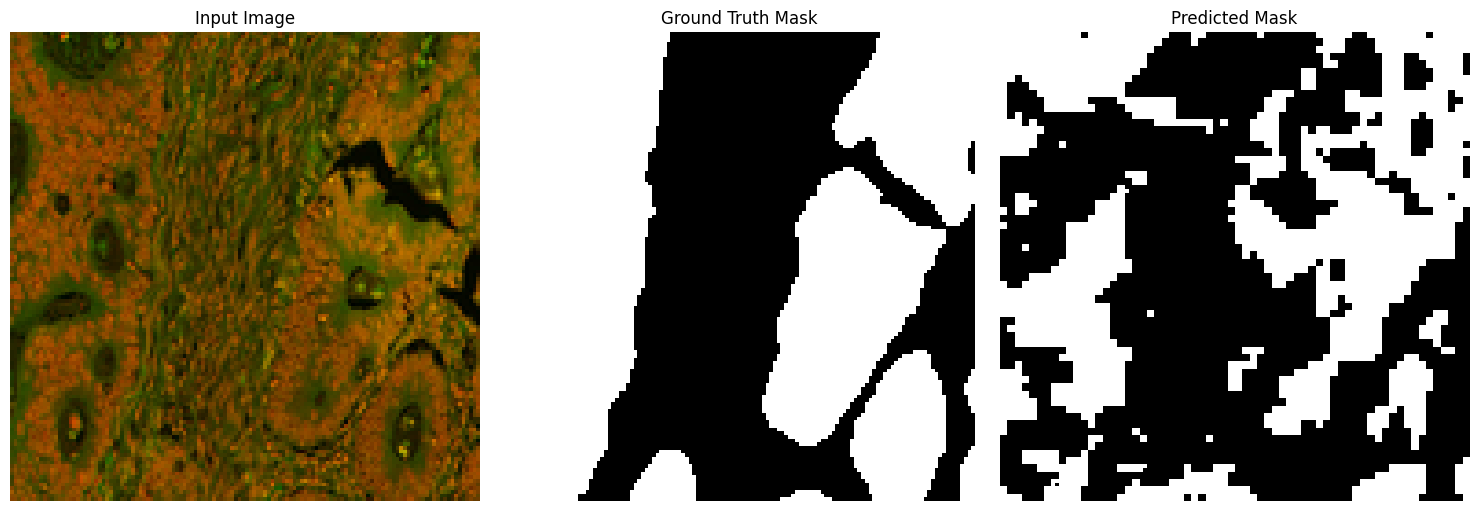

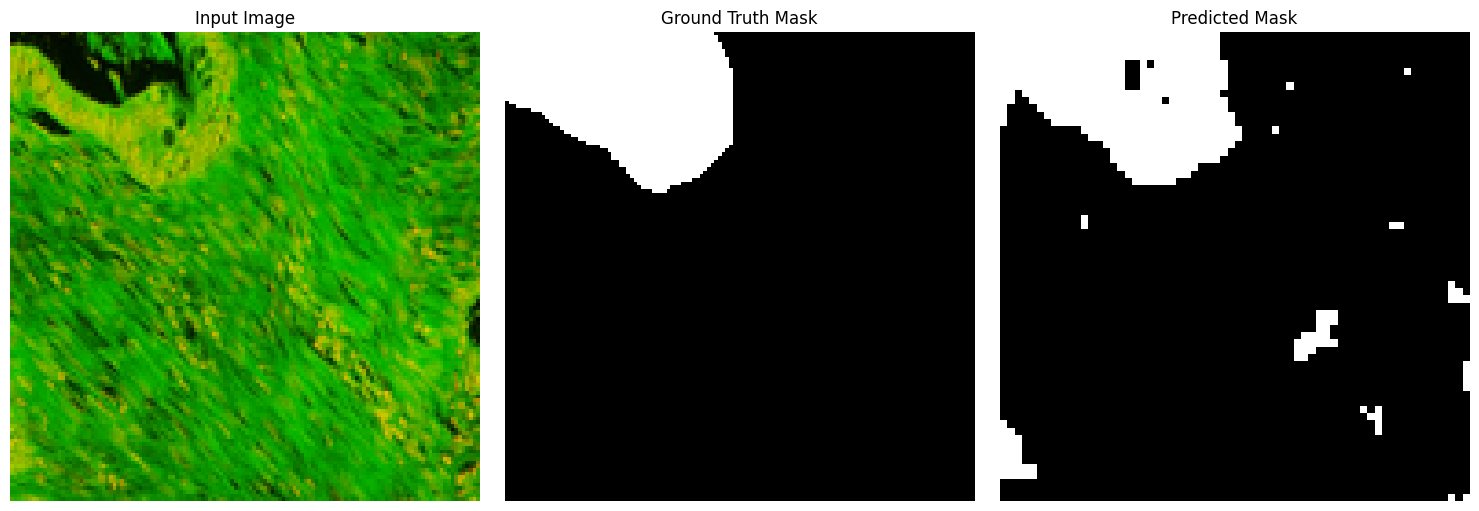

In [122]:
best_case, worst_case = find_best_and_worst_case(model, X_test, Y_test, device)
# Visualize the first case
visualize_case(best_case)

# Visualize the second case
visualize_case(worst_case)

In [120]:
import torch
# Example tensor
tensor = model(worst_case["input"].unsqueeze(0).to(device)).detach().cpu()

# Set negative values to 0 and positive values to 1
result = torch.where(tensor < 0, torch.tensor(0), torch.tensor(1))

print(result)


tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 1, 1]])
